# Прогноз количества заказов для сервиса такси
Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.

Данные лежат в файле '/datasets/taxi.csv'
* datetime - начало временного промежутка в 10 минут
* num orders - количество заказов за этот промежуток

## Загрузка данных

In [1]:
!pip install catboost -q

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.dates as mdates

In [3]:
try:
    taxi_df = pd.read_csv('taxi.csv')
except:
    taxi_df = pd.read_csv('/datasets/taxi.csv')    

In [4]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
taxi_df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Приведём тип колонки datetime к временному и сделаем индексацию по ней

In [6]:
taxi_df['datetime'] = pd.to_datetime(taxi_df['datetime'])
taxi_df.set_index('datetime', inplace=True)

Отсортируем по возрастанию времени заказа

In [7]:
taxi_df.sort_index(inplace=True)

## Исследовательский анализ

In [8]:
print('Доля пропусков:', taxi_df.isna().mean())
print(taxi_df['num_orders'].describe())

Доля пропусков: num_orders    0.0
dtype: float64
count    26496.000000
mean        14.070463
std          9.211330
min          0.000000
25%          8.000000
50%         13.000000
75%         19.000000
max        119.000000
Name: num_orders, dtype: float64


Посмортим за какой промежуток наши данные

In [9]:
print(f"Минимальное время: {taxi_df.index.min()}, Максимальное время: {taxi_df.index.max()}")

Минимальное время: 2018-03-01 00:00:00, Максимальное время: 2018-08-31 23:50:00


Сэмплируем данные по часам

In [10]:
taxi_df_hourly = taxi_df.resample('h').sum()

Проверка и визулизация данных

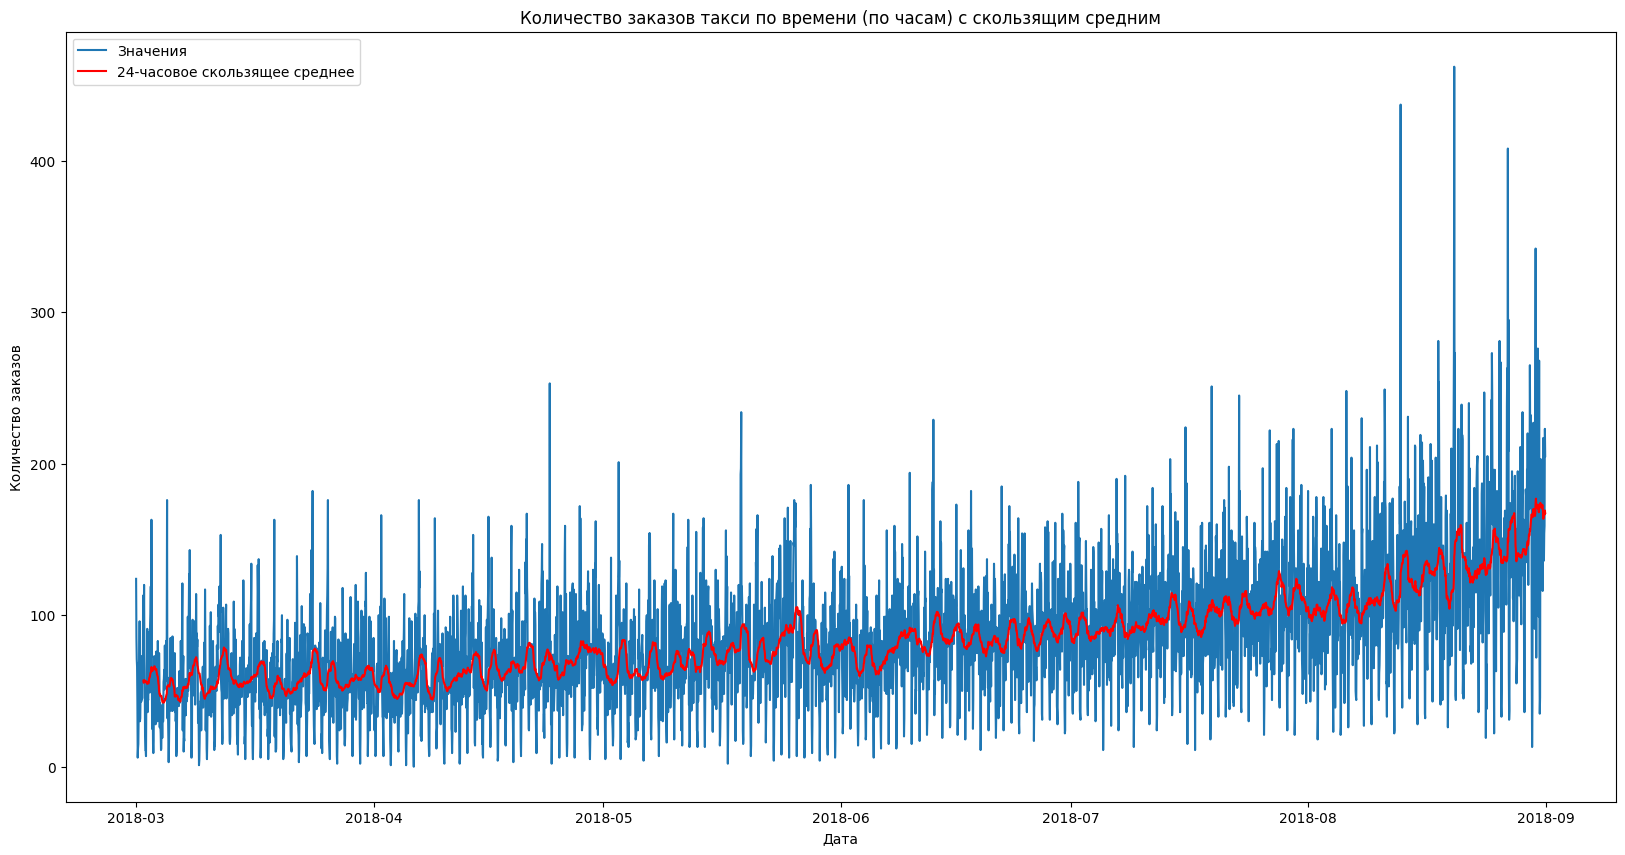

In [11]:
plt.figure(figsize=(20, 10))

plt.plot(taxi_df_hourly.index, taxi_df_hourly['num_orders'], label='Значения')
rolling_mean = taxi_df_hourly['num_orders'].rolling(window=24).mean()
plt.plot(taxi_df_hourly.index, rolling_mean, label='24-часовое скользящее среднее', color='red')

plt.title('Количество заказов такси по времени (по часам) с скользящим средним')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.legend()
plt.show()

Как видим на протяжении нескольких месяцев количество заказов стабильно растёт, теперь рассмотрим разные состовляющие временного ряда

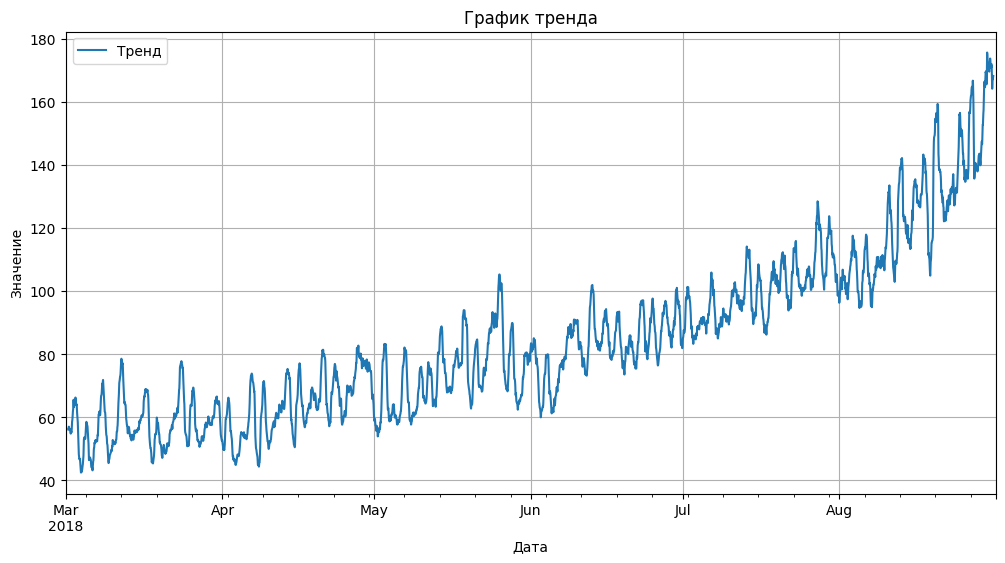

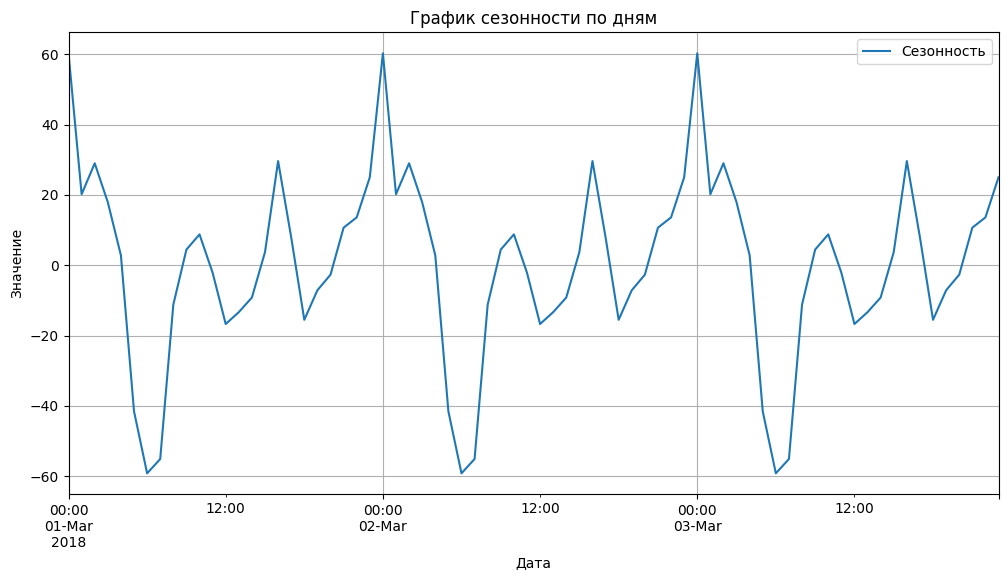

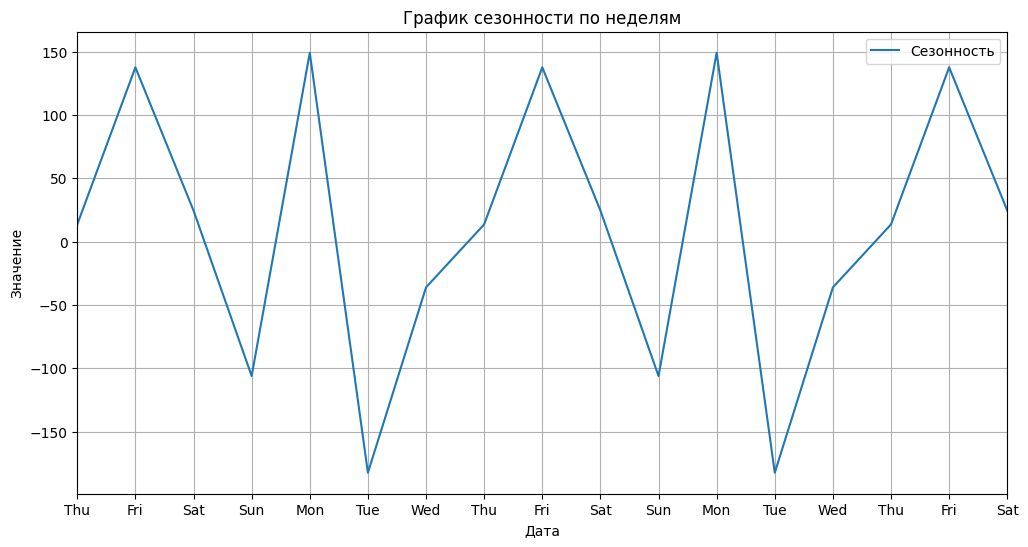

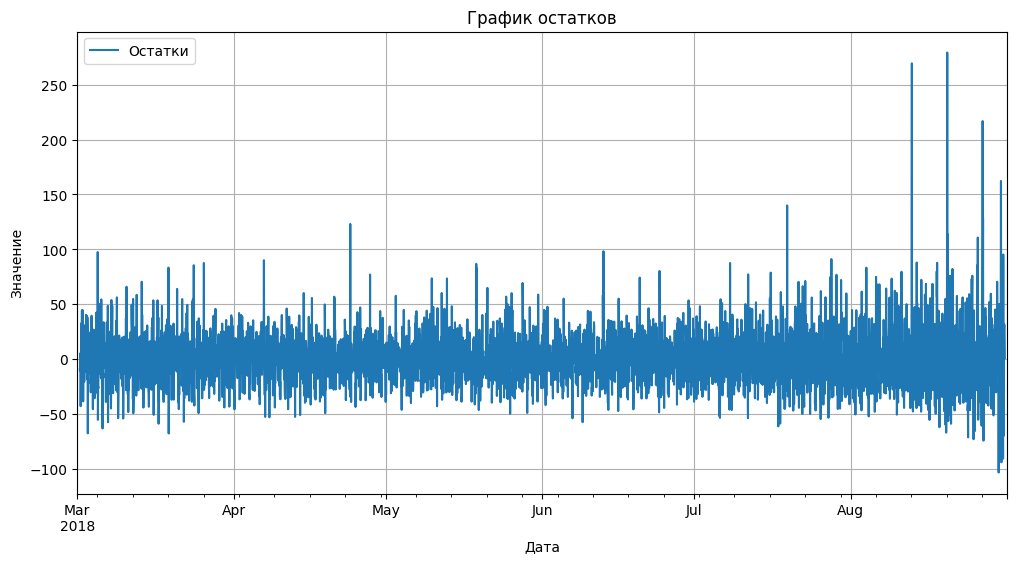

In [12]:
decomposed = seasonal_decompose(taxi_df_hourly)


plt.figure(figsize=(12, 6))
decomposed.trend.plot()
plt.title('График тренда')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend(['Тренд'])
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
decomposed.seasonal['2018.03.01':'2018.03.03'].plot()
plt.title('График сезонности по дням')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend(['Сезонность'])
plt.grid(True)
plt.show()


plt.figure(figsize=(12, 6))
result = seasonal_decompose(taxi_df_hourly.resample('D').sum())
result.seasonal['2018-03-01':'2018-03-17'].plot()
plt.title('График сезонности по неделям')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend(['Сезонность'])
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%a'))
plt.show()


plt.figure(figsize=(12, 6))
decomposed.resid.plot()
plt.title('График остатков')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend(['Остатки'])
plt.grid(True)
plt.show()

По графику тренда видно, что с течением времени количество заказов растёт. По графику сезонности можно определить, что каждый деньнаибольшее количество заказов приходиться на полночь, а наименьшее примерно на 6 утра, по недельной сезонности видно, что наибольшее количество заказов в понедельник и пятницу. Остатки же никак не интерпретируемы.

## Предобработка данных
Попробуем создать дополнительные признаки

In [13]:
def make_features(data, max_lag, rolling_mean_size):
    data_copy = data.copy()
    data_copy['hour'] = data_copy.index.hour
    data_copy['dayofweek'] = data_copy.index.dayofweek
    for lag in range(1, max_lag + 1):
        data_copy[f'lag_{lag}'] = data_copy['num_orders'].shift(lag)
    data_copy['rolling_mean'] = data_copy['num_orders'].shift().rolling(rolling_mean_size).mean()
    data_copy = data_copy.dropna()
    return data_copy

taxi_df_hourly_updated = make_features(taxi_df_hourly, 24, 24)

## Обучение моделей

Разделим на тестовую и обучающую выборку

In [14]:
train_valid, test = train_test_split(taxi_df_hourly_updated, test_size=0.1, random_state=42, shuffle=False)

Найдём baseline RMSE используя для предсказания следующего значения предыдущее

In [15]:
y_pred_dummy = test.shift(1)
y_pred_dummy.iloc[0] = test.iloc[0]
rmse_dummy = root_mean_squared_error(test['num_orders'], y_pred_dummy['num_orders'])
results = {'dummy': rmse_dummy}
print('Baseline RMSE =', rmse_dummy)

Baseline RMSE = 58.86322744680711


Теперь используя gridsearch подберём лучшую стандартную модель.

In [16]:
X_train_valid = train_valid.drop('num_orders', axis=1)
y_train_valid = train_valid['num_orders']

X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

In [17]:
final_p = Pipeline(steps=[
    ('preprocessing', StandardScaler()),
    ('models', RandomForestRegressor(random_state=42))
])

Создадим словарь для перебора гиперпараметров

In [18]:
param_grid = [
    {
        'models': [RandomForestRegressor(random_state=42)],
        'models__max_depth': range(2, 4),
        'models__min_samples_split': range(2, 3),
    },

    {
        'models': [LinearRegression()],
        'models__fit_intercept': [True, False],
    },
    {
        'models': [SVR()],
        'models__kernel': ['linear', 'rbf'],
        'models__C': [0.1, 1],
        'models__gamma': ['scale', 'auto'],
    }
]

Создадим scorer для gridSearch, чтобы оценивать RMSE, для временных рядов нельзя использовать обычную кросс-валидацию, поэтому воспользуемся TimeSeriesSplit

In [19]:
tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(estimator=final_p, param_grid=param_grid, cv=tscv, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train_valid, y_train_valid);

In [20]:
best_params = grid_search.best_params_
best_score = -grid_search.best_score_   

print("Лучшие параметры:", best_params)
print("Лучшая оценка (RMSE) на обучающих данных:", best_score)
results[best_params['models']] = best_score

Лучшие параметры: {'models': LinearRegression(), 'models__fit_intercept': True}
Лучшая оценка (RMSE) на обучающих данных: 27.140267948787358


Достойная метрика получена у линейной регрессии, почти в 2 раза меньше, чем у dummy модели.

Рассмотрим catboost

In [21]:
catboost_model = CatBoostRegressor()

tscv = TimeSeriesSplit(n_splits=5)
cv_rmse = -cross_val_score(catboost_model, X_train_valid, y_train_valid, scoring='neg_root_mean_squared_error', cv=tscv)

Learning rate set to 0.03836
0:	learn: 29.1687954	total: 137ms	remaining: 2m 16s
1:	learn: 28.6645910	total: 141ms	remaining: 1m 10s
2:	learn: 28.1430091	total: 145ms	remaining: 48.1s
3:	learn: 27.7039117	total: 148ms	remaining: 37s
4:	learn: 27.2469579	total: 152ms	remaining: 30.2s
5:	learn: 26.8451620	total: 156ms	remaining: 25.8s
6:	learn: 26.4203789	total: 160ms	remaining: 22.7s
7:	learn: 26.0283954	total: 164ms	remaining: 20.3s
8:	learn: 25.6362117	total: 168ms	remaining: 18.5s
9:	learn: 25.3247500	total: 172ms	remaining: 17s
10:	learn: 24.9051561	total: 177ms	remaining: 15.9s
11:	learn: 24.5882530	total: 181ms	remaining: 14.9s
12:	learn: 24.2616327	total: 186ms	remaining: 14.1s
13:	learn: 23.9555497	total: 191ms	remaining: 13.4s
14:	learn: 23.6186119	total: 195ms	remaining: 12.8s
15:	learn: 23.3511988	total: 200ms	remaining: 12.3s
16:	learn: 23.0955337	total: 204ms	remaining: 11.8s
17:	learn: 22.8102744	total: 208ms	remaining: 11.4s
18:	learn: 22.5796181	total: 213ms	remaining: 1

In [22]:
print("Среднее значение RMSE на временной кросс-валидации:", cv_rmse.mean())
results['catboost'] = cv_rmse.mean()

Среднее значение RMSE на временной кросс-валидации: 24.2447042040056


Как видим CatBoost уже из коробки показывает метрику чуть хуже, чем лучшая из подобранных на простых моделях

Рассмотрим модель SARIMA, специально предназначенную для анализа временных рядов

In [23]:
order = (1, 1, 1)                   
seasonal_order = (1, 1, 1, 24)

train_valid_orig, test_orig = train_test_split(taxi_df_hourly, test_size=0.1, random_state=42, shuffle=False)
train_orig, valid_orig = train_test_split(train_valid_orig, test_size=0.2, random_state=42, shuffle=False)

Обучим модель SARIMA

In [24]:
model_sarima = SARIMAX(train_orig, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
result = model_sarima.fit(disp=False)

forecast = result.get_forecast(steps=len(valid_orig))
forecast_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

Построим графики для предсказанных и значений и их доверительные интервалы

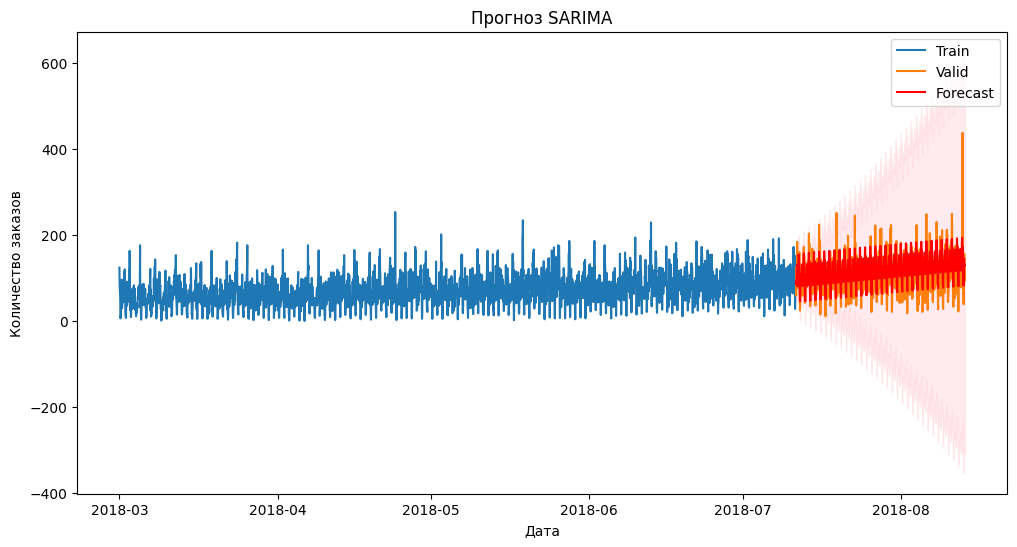

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(train_orig.index, train_orig, label='Train')
plt.plot(valid_orig.index, valid_orig, label='Valid')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_mean.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Прогноз SARIMA')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.legend()
plt.show()

In [26]:
rmse_sarima = root_mean_squared_error(valid_orig, forecast_mean)
results['sarima'] = rmse_sarima
print('RMSE на валидационных данных:', rmse_sarima)

RMSE на валидационных данных: 32.32211558125809


In [27]:
models = pd.DataFrame(data=results.items(), columns=['name', 'RMSE'])
models

,name,RMSE
0,dummy,58.863227
1,LinearRegression(),27.140268
2,catboost,24.244704
3,sarima,32.322116


Как видим лучшая модель это CatBoost, но так-как эта оценка получена на кросс валидации, а для SARIMA кросс валидация не использовалась, то проверим LinearRegression на валидационном наборе

In [28]:
model_catboost = CatBoostRegressor()
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=42, shuffle=False)

In [29]:
model_catboost.fit(X_train, y_train)
y_pred_catboost = model_catboost.predict(X_valid)

Learning rate set to 0.049108
0:	learn: 33.4574413	total: 8.85ms	remaining: 8.84s
1:	learn: 32.7861455	total: 16.7ms	remaining: 8.34s
2:	learn: 32.0657170	total: 24.4ms	remaining: 8.12s
3:	learn: 31.4387864	total: 32.1ms	remaining: 7.99s
4:	learn: 30.8355214	total: 40.8ms	remaining: 8.12s
5:	learn: 30.2951490	total: 48.8ms	remaining: 8.09s
6:	learn: 29.7885618	total: 57.9ms	remaining: 8.21s
7:	learn: 29.2989999	total: 66.1ms	remaining: 8.2s
8:	learn: 28.8428433	total: 74ms	remaining: 8.15s
9:	learn: 28.4056483	total: 81.8ms	remaining: 8.1s
10:	learn: 27.9825785	total: 89.7ms	remaining: 8.06s
11:	learn: 27.6015867	total: 97.5ms	remaining: 8.03s
12:	learn: 27.2180515	total: 106ms	remaining: 8.03s
13:	learn: 26.8674724	total: 113ms	remaining: 7.99s
14:	learn: 26.5415902	total: 121ms	remaining: 7.95s
15:	learn: 26.2252959	total: 129ms	remaining: 7.92s
16:	learn: 25.9033059	total: 137ms	remaining: 7.91s
17:	learn: 25.5951969	total: 144ms	remaining: 7.88s
18:	learn: 25.3166206	total: 152ms	r

In [30]:
print('RMSE линейной модели на валидационной выборке:', root_mean_squared_error(y_valid, y_pred_catboost))

RMSE линейной модели на валидационной выборке: 31.850820745433516


Это ниже, чем у SARIMA, так что на тесте воспользуемся ей

## Проверка модели на тесте

Создадим и обучим модель

In [31]:
model_final = CatBoostRegressor()
model_final.fit(X_train_valid, y_train_valid)
y_pred_final = model_final.predict(X_test)

Learning rate set to 0.050872
0:	learn: 37.8068076	total: 7.34ms	remaining: 7.34s
1:	learn: 36.9012802	total: 14.2ms	remaining: 7.07s
2:	learn: 36.0875483	total: 20.8ms	remaining: 6.93s
3:	learn: 35.2839474	total: 27.5ms	remaining: 6.86s
4:	learn: 34.5669170	total: 33.6ms	remaining: 6.68s
5:	learn: 33.9221889	total: 39.7ms	remaining: 6.58s
6:	learn: 33.2935952	total: 45.7ms	remaining: 6.48s
7:	learn: 32.7238609	total: 51.9ms	remaining: 6.44s
8:	learn: 32.1660283	total: 58.5ms	remaining: 6.44s
9:	learn: 31.6553529	total: 65.1ms	remaining: 6.44s
10:	learn: 31.1350788	total: 71.5ms	remaining: 6.43s
11:	learn: 30.6879138	total: 78ms	remaining: 6.42s
12:	learn: 30.2188453	total: 84.8ms	remaining: 6.44s
13:	learn: 29.7905519	total: 91.4ms	remaining: 6.43s
14:	learn: 29.3726844	total: 97.9ms	remaining: 6.43s
15:	learn: 29.0050401	total: 104ms	remaining: 6.4s
16:	learn: 28.6578774	total: 110ms	remaining: 6.35s
17:	learn: 28.3312837	total: 116ms	remaining: 6.34s
18:	learn: 28.0220425	total: 123

In [32]:
rmse_final = root_mean_squared_error(y_test, y_pred_final)
print('RMSE на тестовых данных:', rmse_final)

RMSE на тестовых данных: 40.035840464247066


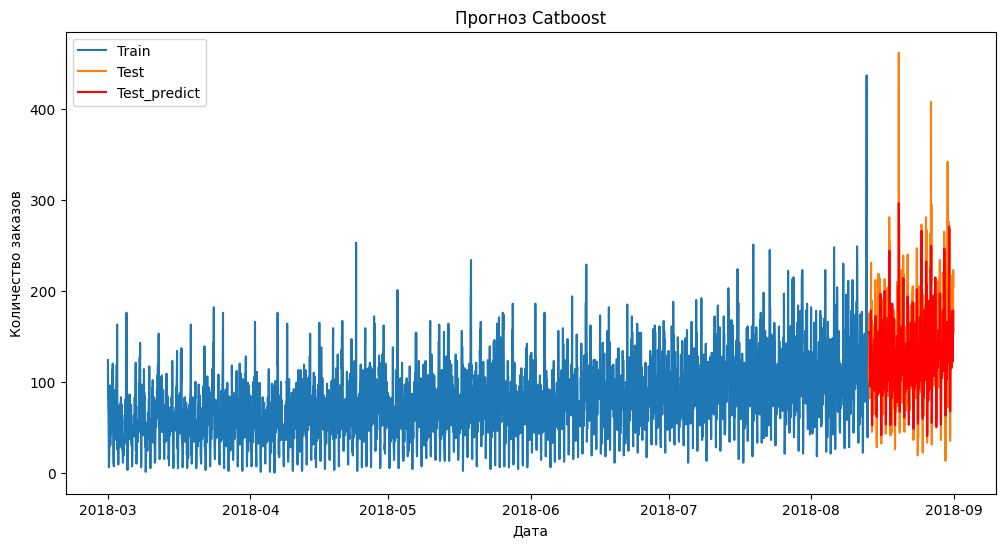

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(train_valid_orig.index, train_valid_orig, label='Train')
plt.plot(test_orig.index, test_orig, label='Test')
plt.plot(X_test.index, y_pred_final, label='Test_predict', color='red')
plt.title('Прогноз Catboost')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.legend()
plt.show()

## Вывод
В ходе этого проекта мы провели анализ данных данные и построили модель для предсказания количества вызовов такси в ближайший час
* По графику тренда видно, что с течением времени количество заказов растёт. По графику сезонности можно определить, что каждый день наибольшее количество заказов приходиться на полночь, а наименьшее примерно на 6 утра, по недельной сезонности видно, что наибольшее количество заказов в понедельник и пятницу. Остатки же никак не интерпретируемы.
* В ходе моделирования было проверено несколько простых моделей, catboost и SARIMA и в конченом итоге была выбрана модель CatBoost.

Как показало моделирование мы можем использовать CatBosstRegressor c созданием новых признаков и при этом получать неплохие результаты RMSE = 40.03

